# PART A: TIME SERIES

## TASK: 
### Use air-pollution dataset to train a time series model for future air pollution forecasting

### 328 days of air pollution data is given to predict 63 days of air pollution values for 4 types of pollution gases.

## Data fields
- Date - date
- T - temperature
- RH - relative humidity
- Gas - type of pollution gas
- Value - amount of pollution

Documentation : https://www.kaggle.com/competitions/aiml-2223s1/data

## Import Libraries

In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 22,10
from sklearn.preprocessing import LabelEncoder
import datetime
#SERIE AND ARIMA MODEL LIBRARIES
from pandas import Series
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import warnings
import itertools
warnings.filterwarnings("ignore") # specify to ignore warning messages

Populating the interactive namespace from numpy and matplotlib


In [18]:
df = pd.read_csv("train.csv")
df

,Date,T,RH,Gas,Value,Unnamed: 5,Unnamed: 6
0,15/3/2016,12.020833,54.883334,CO,1053.200000,NaN,NaN
1,16/3/2016,9.833333,64.069791,CO,995.250000,NaN,NaN
2,17/3/2016,11.292708,51.107292,CO,1025.250000,NaN,NaN
3,18/3/2016,12.866319,51.530903,CO,1064.444444,NaN,NaN
4,19/3/2016,16.016667,48.843750,CO,1088.741667,NaN,NaN
...,...,...,...,...,...,...,...
1307,1/2/2017,5.267708,39.614930,O3,553.180556,NaN,NaN
1308,2/2/2017,-55.515972,-24.010417,O3,343.500000,NaN,NaN
1309,3/2/2017,-14.272917,28.563542,O3,334.458333,NaN,NaN
1310,4/2/2017,4.848611,37.832986,O3,379.513889,NaN,NaN


#### Observation

From here we can see that there are 1 column of date, T, RH, Gas and Value and 2 empty columns.


In [19]:
df.loc[df.Date == "15/3/2016"]

,Date,T,RH,Gas,Value,Unnamed: 5,Unnamed: 6
0,15/3/2016,12.020833,54.883334,CO,1053.200000,NaN,NaN
328,15/3/2016,12.020833,54.883334,HC,729.800000,NaN,NaN
656,15/3/2016,12.020833,54.883334,NO2,933.800000,NaN,NaN
984,15/3/2016,12.020833,54.883334,O3,876.833333,NaN,NaN


From here we can see that there are 4 types of gas for each day. On the same day, different gas can have different values of pollution but they all have same T and RH values.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1312 entries, 0 to 1311
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1312 non-null   object 
 1   T           1312 non-null   float64
 2   RH          1312 non-null   float64
 3   Gas         1312 non-null   object 
 4   Value       1312 non-null   float64
 5   Unnamed: 5  0 non-null      float64
 6   Unnamed: 6  0 non-null      float64
dtypes: float64(5), object(2)
memory usage: 71.9+ KB


In [21]:
#changing date to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df

,Date,T,RH,Gas,Value,Unnamed: 5,Unnamed: 6
0,2016-03-15,12.020833,54.883334,CO,1053.200000,NaN,NaN
1,2016-03-16,9.833333,64.069791,CO,995.250000,NaN,NaN
2,2016-03-17,11.292708,51.107292,CO,1025.250000,NaN,NaN
3,2016-03-18,12.866319,51.530903,CO,1064.444444,NaN,NaN
4,2016-03-19,16.016667,48.843750,CO,1088.741667,NaN,NaN
...,...,...,...,...,...,...,...
1307,2017-02-01,5.267708,39.614930,O3,553.180556,NaN,NaN
1308,2017-02-02,-55.515972,-24.010417,O3,343.500000,NaN,NaN
1309,2017-02-03,-14.272917,28.563542,O3,334.458333,NaN,NaN
1310,2017-02-04,4.848611,37.832986,O3,379.513889,NaN,NaN


Setting date as index

In [22]:
#set date as index
#pivot the gases into their own columns
df = df.pivot(index=['Date','T', 'RH'], columns = 'Gas', values = 'Value')
df=df.reset_index()
df=df.set_index('Date')
df

Gas,T,RH,CO,HC,NO2,O3
Date,,,,,,
2016-03-15,12.020833,54.883334,1053.200000,729.800000,933.800000,876.833333
2016-03-16,9.833333,64.069791,995.250000,681.441667,1021.750000,708.025000
2016-03-17,11.292708,51.107292,1025.250000,806.583333,881.375000,867.375000
2016-03-18,12.866319,51.530903,1064.444444,794.258333,794.527778,996.625000
2016-03-19,16.016667,48.843750,1088.741667,755.083333,800.883333,987.341667
...,...,...,...,...,...,...
2017-02-01,5.267708,39.614930,729.422222,562.650000,797.647222,553.180556
2017-02-02,-55.515972,-24.010417,474.291667,347.480556,508.180556,343.500000
2017-02-03,-14.272917,28.563542,615.700000,414.475000,819.733333,334.458333


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328 entries, 2016-03-15 to 2017-02-05
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       328 non-null    float64
 1   RH      328 non-null    float64
 2   CO      328 non-null    float64
 3   HC      328 non-null    float64
 4   NO2     328 non-null    float64
 5   O3      328 non-null    float64
dtypes: float64(6)
memory usage: 17.9 KB


In [24]:
df.loc[df.index == "31/12/2016"]

Gas,T,RH,CO,HC,NO2,O3
Date,,,,,,
2016-12-31,12.045833,74.79375,863.766667,578.966667,735.4,664.216667


### EDA: Exploratory Data Analysis

I then visualized the dataset to get a clearer idea on the dataset:
 - LinePlots to display numerical values over time of all categorical variables
 - LinePlot to see the relation of Temperature over relative humidity
 - Histogram Plots to display the data distribution

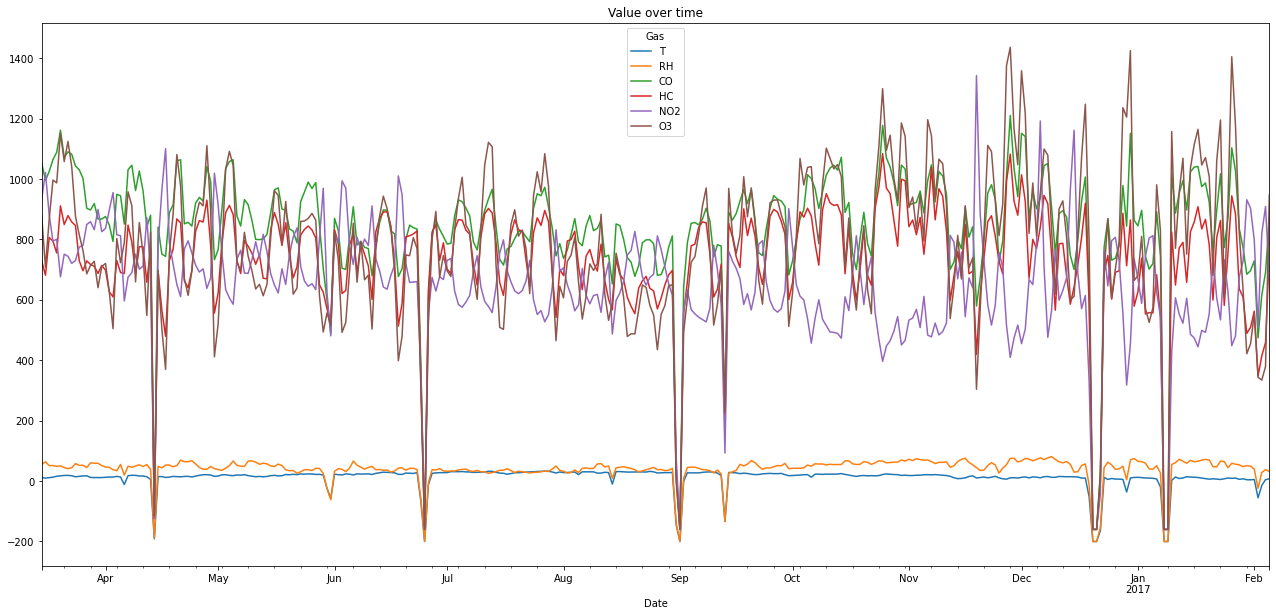

Gas             T          RH           CO           HC          NO2  \
count  328.000000  328.000000   328.000000   328.000000   328.000000   
mean    11.634917   39.873729   840.583477   729.588974   650.087974   
std     37.084233   43.267370   204.831525   190.472814   193.658229   
min   -200.000000 -200.000000  -160.000000  -160.000000  -160.000000   
25%     12.387760   36.348177   779.191667   662.795833   566.095833   
50%     18.832292   46.078993   864.141667   753.681944   659.325000   
75%     25.557118   57.932292   946.431250   847.712500   754.351389   
max     32.997917   81.104167  1210.566667  1084.083333  1342.950000   

Gas             O3  
count   328.000000  
mean    780.614931  
std     261.846007  
min    -160.000000  
25%     639.850000  
50%     794.893056  
75%     944.608333  
max    1436.233333  


In [10]:
df.plot(figsize=(22,10))
plt.title('Value over time')
plt.show()
print(df.describe())

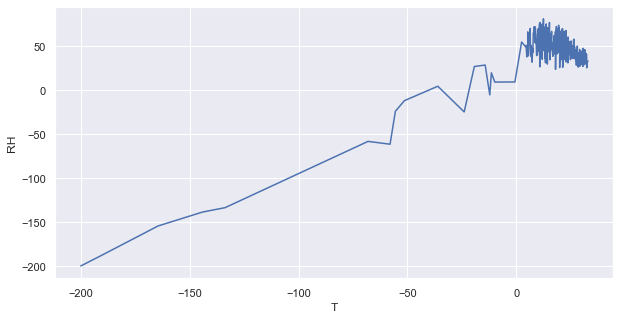

In [15]:
plt.figure(figsize = (10,5))
sns.lineplot(x = "T", y = "RH", data = df)
plt.show()

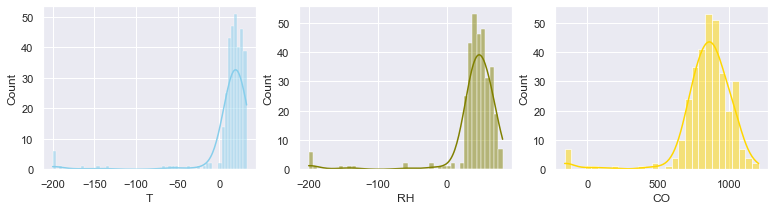

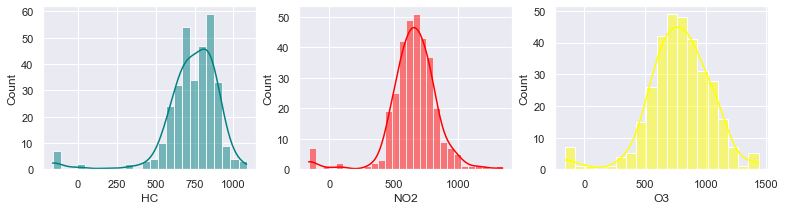

In [13]:
# background style 
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 3, figsize=(13, 3))

sns.histplot(data=df, x="T", kde=True, color="skyblue", ax=axs[0])
sns.histplot(data=df, x="RH", kde=True, color="olive", ax=axs[1])
sns.histplot(data=df, x="CO", kde=True, color="gold", ax=axs[2])

fig, axs = plt.subplots(1, 3, figsize=(13, 3))
sns.histplot(data=df, x="HC", kde=True, color="teal", ax=axs[0])
sns.histplot(data=df, x="NO2", kde=True, color="red", ax=axs[1])
sns.histplot(data=df, x="O3", kde=True, color="yellow", ax=axs[2])

plt.show()

#### Testing for Stationality

From here we can see that the data is stationary

In [49]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print(f'{title} p-value:{dftest[1]}, Reject Null Hypothesis')
        print("Data is Stationary for", title)
    else:
        print(f'{title} p-value:{dftest[1]}, Accept Null Hypothesis')
        print("Data is not Stationary for", title)

In [50]:
test_adf(df['CO'], "CO")
test_adf(df['HC'], "HC")
test_adf(df['NO2'], "NO2")
test_adf(df['O3'], "O3")

CO p-value:1.7881486123589506e-14, Reject Null Hypothesis
Data is Stationary for CO
HC p-value:1.0321425708410129e-14, Reject Null Hypothesis
Data is Stationary for HC
NO2 p-value:4.0089117100054356e-17, Reject Null Hypothesis
Data is Stationary for NO2
O3 p-value:1.2783953403377855e-14, Reject Null Hypothesis
Data is Stationary for O3


In this test, the p-value is less than 0.05, therefore we
reject the null hypothesis. The time series is stationary

#### Checking Trends with Seasonal

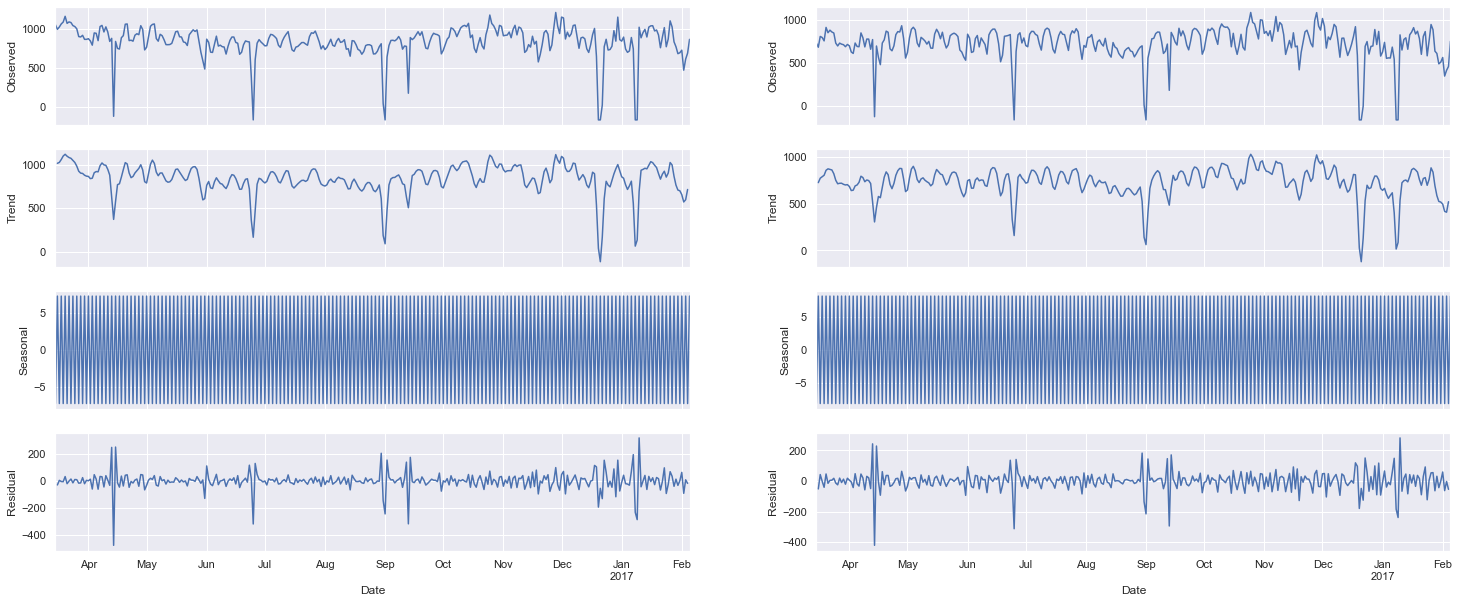

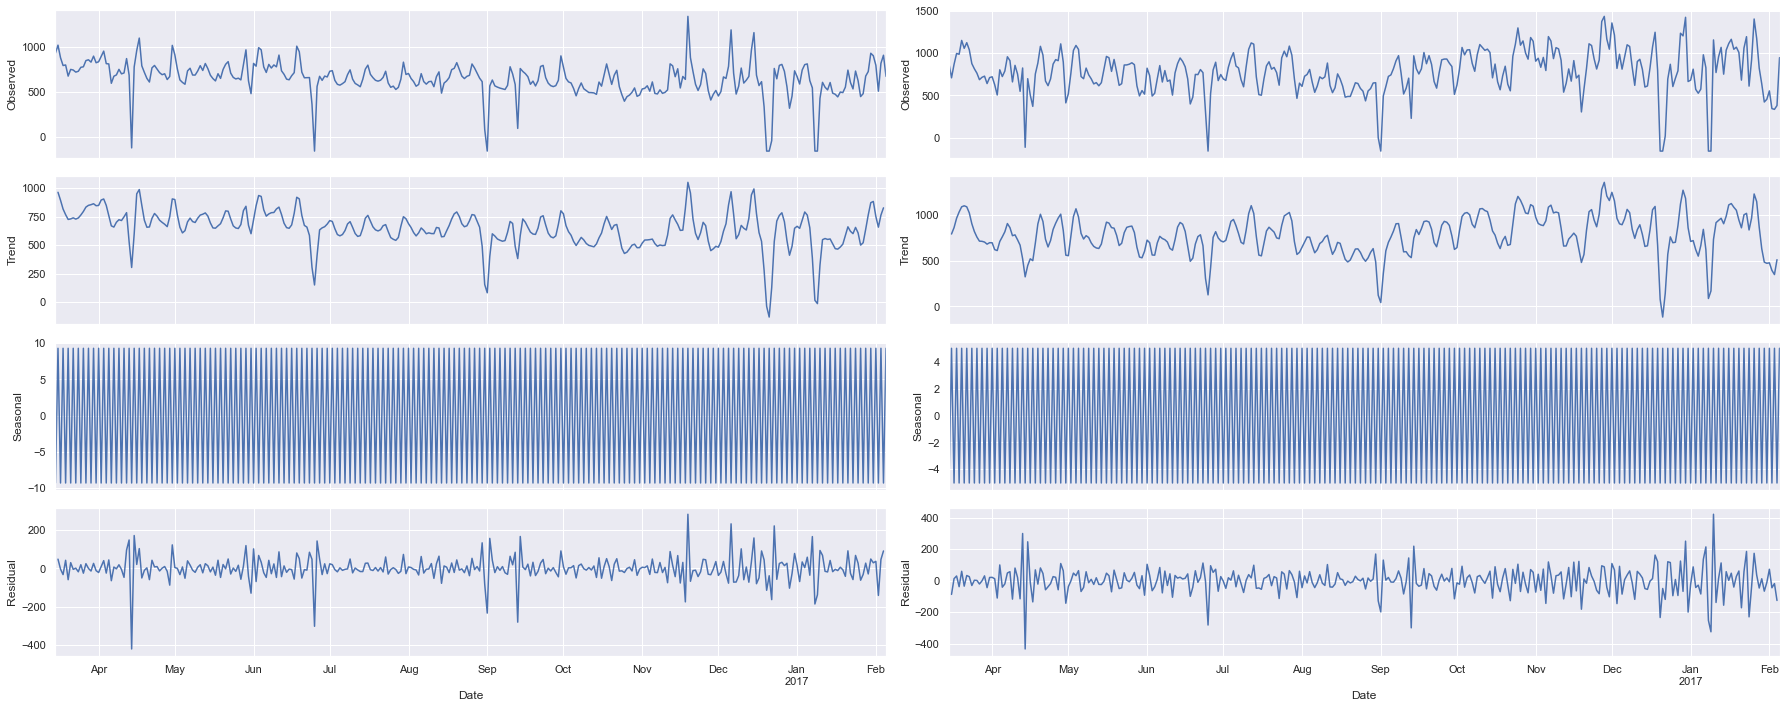

In [17]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
res1 = sm.tsa.seasonal_decompose(df['CO'], model ='addictive', freq=2)
res2 = sm.tsa.seasonal_decompose(df['HC'], model ='addictive', freq=2)
res3 = sm.tsa.seasonal_decompose(df['NO2'], model ='addictive', freq=2)
res4 = sm.tsa.seasonal_decompose(df['O3'], model ='addictive', freq=2)

def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axs = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(25,10))
plotseasonal(res1, axs[:,0])
plotseasonal(res2, axs[:,1])

fig, axs = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(25,10))
plotseasonal(res3, axs[:,0])
plotseasonal(res4, axs[:,1])

plt.tight_layout()
plt.show()

### Plot pacf

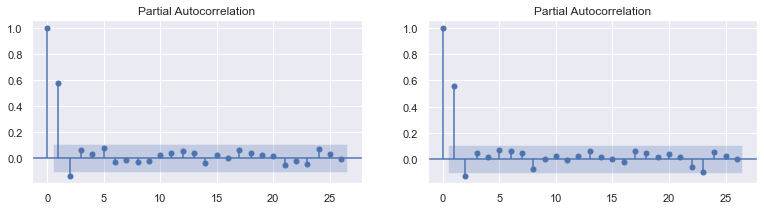

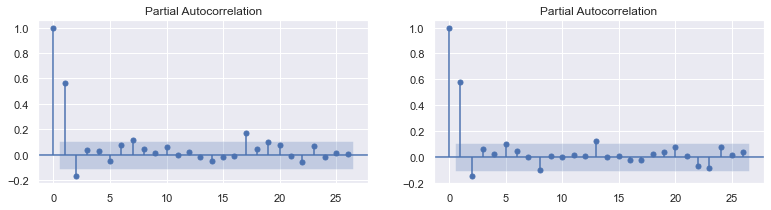

In [48]:
from statsmodels.graphics.tsaplots import plot_pacf
# background style
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 2, figsize=(13, 3))
plot_pacf(df['CO'], ax=axs[0])
plot_pacf(df['HC'], ax=axs[1])

fig, axs = plt.subplots(1, 2, figsize=(13, 3))
plot_pacf(df['NO2'], ax=axs[0])
plot_pacf(df['O3'], ax=axs[1])

plt.show()

### Plot acf

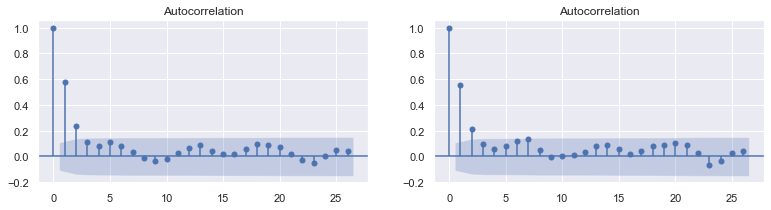

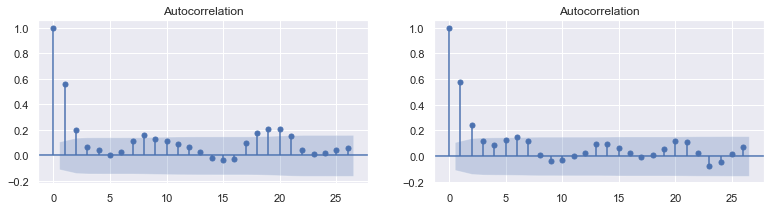

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
# background style
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 2, figsize=(13, 3))
plot_acf(df['CO'], ax=axs[0])
plot_acf(df['HC'], ax=axs[1])

fig, axs = plt.subplots(1, 2, figsize=(13, 3))
plot_acf(df['NO2'], ax=axs[0])
plot_acf(df['O3'], ax=axs[1])

plt.show()

In [33]:
df.count()*0.2

Gas
T      65.6
RH     65.6
CO     65.6
HC     65.6
NO2    65.6
O3     65.6
dtype: float64

### Spliting the dataset into train and testing
The training dataset given is 328 days to predict 63 days, which is about 80% to 20% ratio.

Split dataset into train and testing (328:67), roughly (80:20), made it 67 instead of 66 because start of the month (2016-12-01)

In [25]:
train=df.iloc[:-67]
test=df.iloc[-67:]
display(train)
display(test)

Gas,T,RH,CO,HC,NO2,O3
Date,,,,,,
2016-03-15,12.020833,54.883334,1053.200000,729.800000,933.800000,876.833333
2016-03-16,9.833333,64.069791,995.250000,681.441667,1021.750000,708.025000
2016-03-17,11.292708,51.107292,1025.250000,806.583333,881.375000,867.375000
2016-03-18,12.866319,51.530903,1064.444444,794.258333,794.527778,996.625000
2016-03-19,16.016667,48.843750,1088.741667,755.083333,800.883333,987.341667
...,...,...,...,...,...,...
2016-11-26,7.638542,42.913542,795.025000,685.983333,707.091667,918.141667
2016-11-27,6.451042,54.325000,1012.616667,991.797222,515.586111,1375.763889
2016-11-28,10.731250,75.313542,1210.566667,1082.483333,409.450000,1436.233333


Gas,T,RH,CO,HC,NO2,O3
Date,,,,,,
2016-12-01,12.494792,66.787500,1151.566667,1014.225000,455.058333,1358.375000
2016-12-02,13.768750,75.313541,1140.800000,925.725000,503.475000,1215.200000
2016-12-03,10.640278,72.664583,872.197222,671.600000,667.450000,820.147222
2016-12-04,13.770833,67.261458,959.133333,800.225000,650.583333,986.966667
2016-12-05,12.994097,71.594097,901.669444,769.802778,785.516667,811.016667
...,...,...,...,...,...,...
2017-02-01,5.267708,39.614930,729.422222,562.650000,797.647222,553.180556
2017-02-02,-55.515972,-24.010417,474.291667,347.480556,508.180556,343.500000
2017-02-03,-14.272917,28.563542,615.700000,414.475000,819.733333,334.458333


#### Split Exog variables into training and testing

Temperature and relative humidity are Exogenous variables

They are not influenced by other variables in the system and the output variable depends on them

In [26]:
#Split exog
exog_train = df[['T','RH']].iloc[:-67]
exog_test= df[['T','RH']].iloc[-67:]

In [27]:
gas=['CO', 'HC', 'NO2', 'O3']

### Moving Average (MA)

Moving Average: averages of a
designated number of consecutive
time series values


Set all moving average windows to 12 (ma_window=12) just to test the gases

Using this as a simple baseline to compare

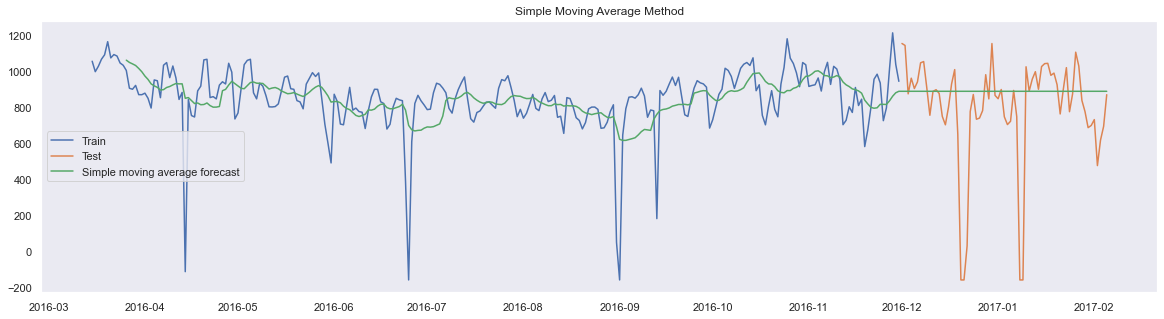

,Gas,train_MAPE,test_MAPE,RMSE
0,CO,9.79,18.01,307.85


In [48]:
#CO gas
y_hat_sma = df.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = df['CO'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][-67:] = y_hat_sma['sma_forecast'][-67-1]
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['CO'], label='Train')
plt.plot(test['CO'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()
train_mape=round(np.mean(np.abs((train['CO'])-y_hat_sma['sma_forecast'][:-67])/train['CO'])*100,2)  # MAPE
test_mape=round(np.mean(np.abs((test['CO'])-y_hat_sma['sma_forecast'][-67:])/test['CO'])*100,2)
rmse=np.sqrt(mean_squared_error((test['CO']), y_hat_sma['sma_forecast'][-67:])).round(2) # RMSE
results = pd.DataFrame({'Gas':['CO'], 'train_MAPE': [train_mape], 'test_MAPE': [test_mape], 'RMSE': [rmse]})
results = results[['Gas', 'train_MAPE', 'test_MAPE', 'RMSE']]
results

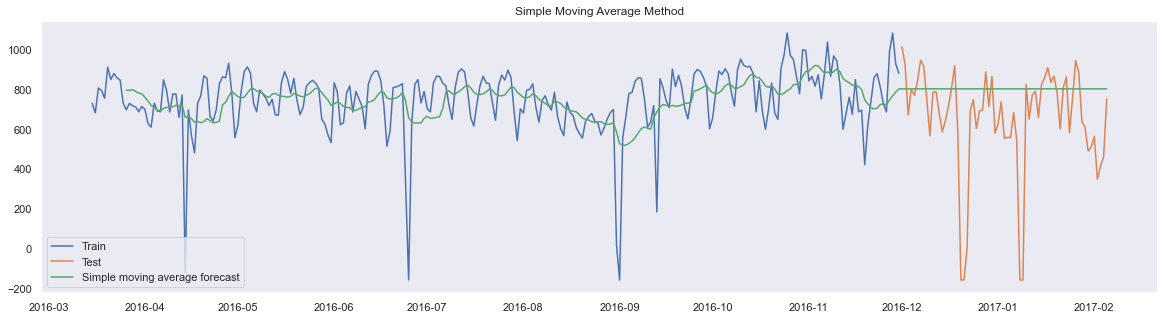

,Gas,train_MAPE,test_MAPE,RMSE
0,HC,22.69,-7199.63,301.51


In [51]:
#HC Gas
y_hat_sma = df.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = df['HC'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][-67:] = y_hat_sma['sma_forecast'][-67-1]
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['HC'], label='Train')
plt.plot(test['HC'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()
train_mape=round(np.mean(np.abs((train['HC'])-y_hat_sma['sma_forecast'][:-67])/train['HC'])*100,2)  # MAPE
test_mape=round(np.mean(np.abs((test['HC'])-y_hat_sma['sma_forecast'][-67:])/test['HC'])*100,2)
rmse=np.sqrt(mean_squared_error((test['HC']), y_hat_sma['sma_forecast'][-67:])).round(2) # RMSE
results = pd.DataFrame({'Gas':['HC'], 'train_MAPE': [train_mape], 'test_MAPE': [test_mape], 'RMSE': [rmse]})
results = results[['Gas', 'train_MAPE', 'test_MAPE', 'RMSE']]
results

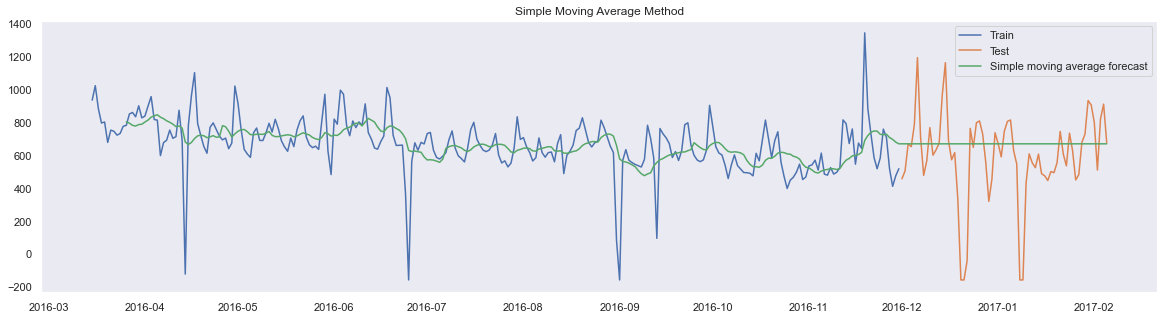

,Gas,train_MAPE,test_MAPE,RMSE
0,NO2,11.02,-34.18,275.8


In [46]:
#NO2 Gas
y_hat_sma = df.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = df['NO2'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][-67:] = y_hat_sma['sma_forecast'][-67-1]
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['NO2'], label='Train')
plt.plot(test['NO2'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()
train_mape=round(np.mean(np.abs((train['NO2'])-y_hat_sma['sma_forecast'][:-67])/train['NO2'])*100,2)  # MAPE
test_mape=round(np.mean(np.abs((test['NO2'])-y_hat_sma['sma_forecast'][-67:])/test['NO2'])*100,2)
rmse=np.sqrt(mean_squared_error((test['NO2']), y_hat_sma['sma_forecast'][-67:])).round(2) # RMSE
results = pd.DataFrame({'Gas':['NO2'], 'train_MAPE': [train_mape], 'test_MAPE': [test_mape], 'RMSE': [rmse]})
results = results[['Gas', 'train_MAPE', 'test_MAPE', 'RMSE']]
results

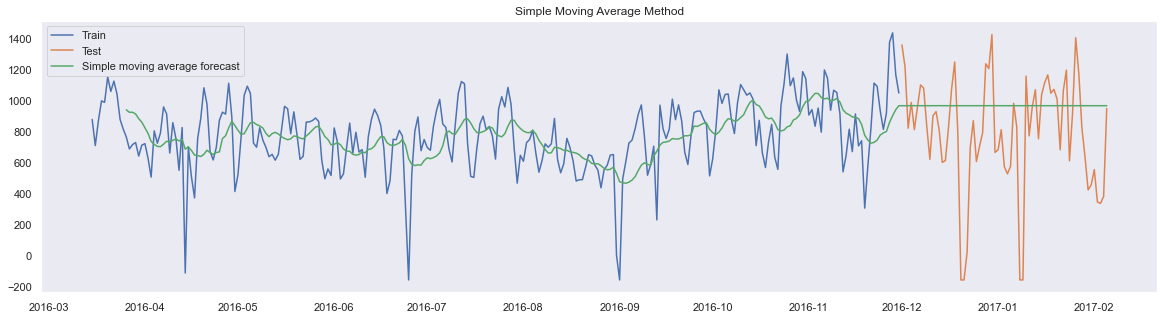

,Gas,train_MAPE,test_MAPE,RMSE
0,O3,-202.42,66.29,403.57


In [47]:
#O3 Gas
y_hat_sma = df.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = df['O3'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][-67:] = y_hat_sma['sma_forecast'][-67-1]
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['O3'], label='Train')
plt.plot(test['O3'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()
train_mape=round(np.mean(np.abs((train['O3'])-y_hat_sma['sma_forecast'][:-67])/train['O3'])*100,2)  # MAPE
test_mape=round(np.mean(np.abs((test['O3'])-y_hat_sma['sma_forecast'][-67:])/test['O3'])*100,2)
rmse=np.sqrt(mean_squared_error((test['O3']), y_hat_sma['sma_forecast'][-67:])).round(2) # RMSE
results = pd.DataFrame({'Gas':['O3'], 'train_MAPE': [train_mape], 'test_MAPE': [test_mape], 'RMSE': [rmse]})
results = results[['Gas', 'train_MAPE', 'test_MAPE', 'RMSE']]
results

# Arima

## Model Fitting
### Find the best combinations of the orders for arima model

In [71]:
# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = (0, 1, 2, 3, 4, 5)
d = (0, 1, 2)
q = (0, 1, 2, 3, 4, 5)
# Generate all different combinations of p, q and q triplets
orders = list(itertools.product(p, d, q))
print(orders)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 5), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 0, 5), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 1, 5), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 2, 4), (1, 2, 5), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 0, 4), (2, 0, 5), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (2, 1, 5), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 2, 4), (2, 2, 5), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 0, 4), (3, 0, 5), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 1, 4), (3, 1, 5), (3, 2, 0), (3, 2, 1), (3, 2, 2), (3, 2, 3), (3, 2, 4), (3, 2, 5), (4, 0, 0), (4, 0, 1), (4, 0, 2), (4, 0, 3), (4, 0, 4), (4, 0, 5), (4, 1, 0), (4, 1, 1), (4, 1, 2), (4, 1, 3), (4, 1, 4), (4, 1, 5), (4, 2, 0), (4, 2, 1), (4, 2, 2), (4, 2, 3), (4, 2, 4), (4, 2, 5), (5, 0, 0)

### Make a for loop to run all the gases and the orders generated through Arima model

Print out the forecasting statistics and sort by rmse because submissions to Kaggle are evaluated on RMSE between forecasts and actual values. 

In [72]:
prediction_df = pd.DataFrame()
metrics_df = pd.DataFrame(columns=['Gas', 'Model', 'Mape_train', 'Mape_test', 'AIC', 'RMSE', 'ME', 'MAE'])
warnings.filterwarnings("ignore")
for gas in gas:
        for order in orders:
            try:
                #ARIMA model
                model = ARIMA(train[gas], exog=exog_train, order=order)  
                fitted = model.fit()

                # Forecast
                fc1, se1, conf1 = fitted.forecast(261, exog=exog_train, alpha=0.05)
                fc2, se2, conf2 = fitted.forecast(67, exog=exog_test, alpha=0.05)  # 95% conf

                # Make as pandas series
                fc_series = pd.Series(fc2, index=test[gas].index)
                lower_series = pd.Series(conf2[:, 0], index=test[gas].index)
                upper_series = pd.Series(conf2[:, 1], index=test[gas].index)
                mape_train= round(np.mean(np.abs(fc1 - train[gas].values)/np.abs(train[gas].values)*100), 2)  # MAPE_train
                mape_test= round(np.mean(np.abs(fc2 - test[gas].values)/np.abs(test[gas].values)*100), 2)  # MAPE_test
                me= round(np.mean(fc2 - test[gas].values),2)             # ME
                mae= round(np.mean(np.abs(fc2 - test[gas].values)),2)    # MAE
                rmse= round(np.mean((fc2 - test[gas].values)**2)**.5,2)  # RMSE
                metrics_df =metrics_df.append({'Gas': gas,'Model': f'{order}', 'Mape_train':mape_train, 'Mape_test':mape_test, 'AIC':fitted.aic, 'RMSE':rmse, 'ME':me, 'MAE': mae, },ignore_index=True)
            except:
                pass
                # ignore the error and go on
        print('For Gas:', gas)
        display(metrics_df.loc[metrics_df['Gas'] == gas].sort_values('RMSE'))

For Gas: CO


,Gas,Model,Mape_train,Mape_test,AIC,RMSE,ME,MAE
1,CO,"(0, 0, 1)",9.61,10.25,2995.406764,103.17,20.27,84.65
19,CO,"(1, 0, 1)",9.91,11.56,2945.484231,103.38,14.60,85.67
2,CO,"(0, 0, 2)",9.78,11.00,2954.925181,103.50,16.53,85.26
18,CO,"(1, 0, 0)",10.01,12.20,2953.167423,103.53,15.31,86.29
66,CO,"(4, 0, 2)",9.94,11.98,2950.792699,103.78,19.81,86.66
...,...,...,...,...,...,...,...,...
59,CO,"(3, 2, 0)",1139.95,1173.96,3465.514666,12188.66,8020.10,8342.52
86,CO,"(5, 2, 0)",1894.68,1429.91,3421.645343,13277.02,9388.33,9394.98
74,CO,"(4, 2, 0)",1886.37,1450.32,3439.730559,13791.37,9649.51,9664.49
17,CO,"(0, 2, 5)",4008.89,2187.09,3371.165363,16739.65,13060.62,13061.60


For Gas: HC


,Gas,Model,Mape_train,Mape_test,AIC,RMSE,ME,MAE
164,HC,"(4, 0, 2)",15.07,469.84,3022.268246,115.60,27.29,95.71
167,HC,"(4, 0, 5)",16.43,705.40,3007.724169,116.02,29.19,95.90
166,HC,"(4, 0, 4)",15.37,813.89,2995.682539,118.51,31.06,98.34
95,HC,"(0, 0, 5)",13.77,30.63,3066.714628,121.15,26.38,98.44
111,HC,"(1, 0, 3)",13.83,59.15,3063.070906,121.79,26.44,99.22
...,...,...,...,...,...,...,...,...
107,HC,"(0, 2, 5)",3779.30,42283.09,3351.687498,13753.60,10675.88,10675.88
160,HC,"(3, 2, 4)",3754.83,42495.97,3356.038077,13786.70,10707.57,10707.57
194,HC,"(5, 2, 5)",3729.10,43216.23,3352.599731,13860.88,10772.50,10772.50
159,HC,"(3, 2, 3)",5339.94,42079.24,3358.043476,14100.04,10905.61,10905.61


For Gas: NO2


,Gas,Model,Mape_train,Mape_test,AIC,RMSE,ME,MAE
200,NO2,"(0, 0, 5)",16.42,20.41,3155.822457,159.08,-16.78,119.73
246,NO2,"(3, 0, 1)",16.46,19.90,3154.319630,159.14,-20.88,119.21
229,NO2,"(2, 0, 0)",16.47,19.83,3150.594267,159.16,-21.99,119.14
230,NO2,"(2, 0, 1)",16.48,19.83,3152.549382,159.19,-22.18,119.16
231,NO2,"(2, 0, 2)",16.45,20.12,3153.476738,159.20,-19.24,119.50
...,...,...,...,...,...,...,...,...
254,NO2,"(3, 2, 0)",1761.83,1593.08,3466.382666,12358.70,8545.40,8675.58
240,NO2,"(2, 2, 0)",2811.18,1921.93,3505.254029,14024.76,10139.84,10158.61
207,NO2,"(0, 2, 0)",3143.10,2544.52,3603.920049,20768.08,-13660.11,14268.94
257,NO2,"(3, 2, 5)",54495.05,6580.84,4429.720575,39703.01,-32780.28,32780.28


For Gas: O3


,Gas,Model,Mape_train,Mape_test,AIC,RMSE,ME,MAE
286,O3,"(0, 0, 0)",49.73,26.04,3465.936652,239.85,-33.91,193.46
287,O3,"(0, 0, 1)",52.73,25.28,3349.878841,241.21,-44.19,194.51
288,O3,"(0, 0, 2)",61.27,27.44,3323.873033,241.86,-48.23,196.88
307,O3,"(1, 0, 3)",62.63,27.85,3326.344769,243.00,-50.67,198.03
289,O3,"(0, 0, 3)",63.80,28.26,3324.346627,243.48,-50.95,198.64
...,...,...,...,...,...,...,...,...
346,O3,"(3, 2, 3)",20298.93,3189.45,3498.817453,20576.45,16032.83,16032.83
345,O3,"(3, 2, 2)",20739.34,3187.40,3495.895852,20586.19,16031.01,16031.01
373,O3,"(5, 2, 3)",21069.39,3204.87,3501.746226,20668.04,16109.37,16109.37
333,O3,"(2, 2, 5)",21282.59,3222.86,3498.235014,20802.39,16205.90,16205.95


### Print out the best arima models for each gas

In [37]:
train_CO=train['CO']
test_CO=test['CO']
train_HC=train['HC']
test_HC=test['HC']
train_NO2=train['NO2']
test_NO2=test['NO2']
train_O3=train['O3']
test_O3=test['O3']

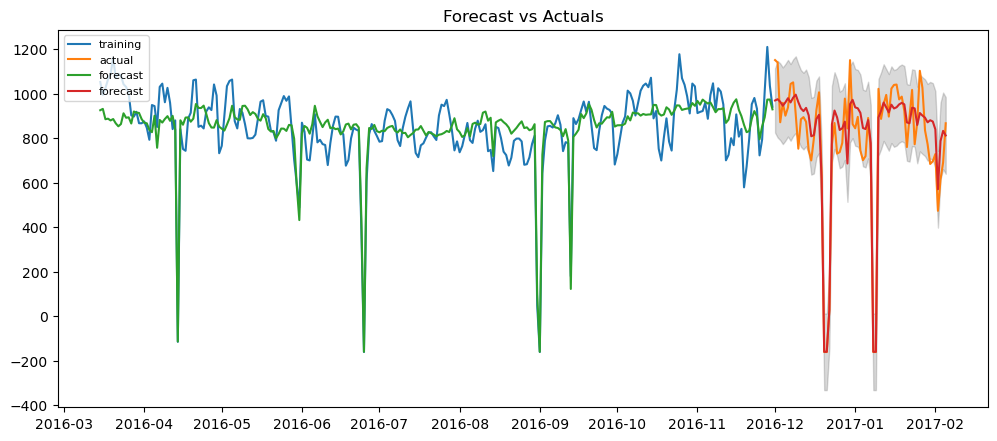

Train_MAPE= 9.61%
Test_MAPE= 10.25%
RMSE= 103.17


In [77]:
# Build Model
# CO Gas
# ARIMA model order=(0, 0, 1))  
model = ARIMA(train_CO, exog=exog_train, order=(0, 0, 1))  
model_visualize= sm.tsa.arima.ARIMA(train_CO, exog=exog_train, order=(0, 0, 1))
fitted = model.fit(disp=-1)  

# Forecast
fc1, se1, conf1 = fitted.forecast(261, exog=exog_train, alpha=0.05)
fc2, se2, conf2 = fitted.forecast(67, exog=exog_test, alpha=0.05)  # 95% conf


# Make as pandas series
fc_series1 = pd.Series(fc1, index=train_CO.index)
fc_series2 = pd.Series(fc2, index=test_CO.index)
lower_series = pd.Series(conf2[:, 0], index=test_CO.index)
upper_series = pd.Series(conf2[:, 1], index=test_CO.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_CO, label='training')
plt.plot(test_CO, label='actual')
plt.plot(fc_series1, label='forecast')
plt.plot(fc_series2, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
print(f'Train_MAPE= {round(np.mean(np.abs(fc1 - train_CO.values)/np.abs(train_CO.values)*100),2)}%')   # MAPE
print(f'Test_MAPE= {round(np.mean(np.abs(fc2 - test_CO.values)/np.abs(test_CO.values)*100),2)}%')
print('RMSE=',round(np.mean((fc2 - test_CO.values)**2)**.5,2)) # RMSE


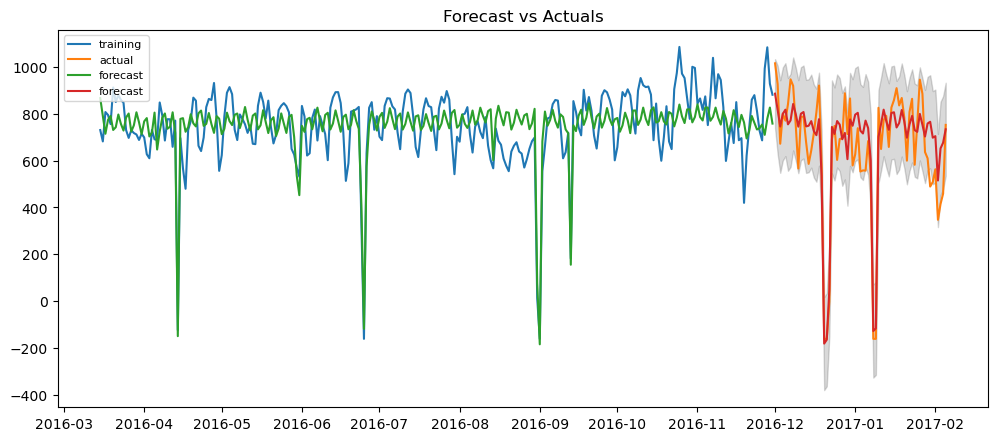

Train_MAPE= 15.07%
Test_MAPE= 469.84%
RMSE= 115.6


In [88]:
# Build Model
# HC Gas
# ARIMA model order=(4, 0, 2))   
model = ARIMA(train_HC, exog=exog_train, order=(4, 0, 2))  
fitted = model.fit(disp=-1)  

# Forecast
fc1, se1, conf1 = fitted.forecast(261, exog=exog_train, alpha=0.05)
fc2, se2, conf2 = fitted.forecast(67, exog=exog_test, alpha=0.05)  # 95% conf


# Make as pandas series
fc_series1 = pd.Series(fc1, index=train_HC.index)
fc_series2 = pd.Series(fc2, index=test_HC.index)
lower_series = pd.Series(conf2[:, 0], index=test_HC.index)
upper_series = pd.Series(conf2[:, 1], index=test_HC.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_HC, label='training')
plt.plot(test_HC, label='actual')
plt.plot(fc_series1, label='forecast')
plt.plot(fc_series2, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
print(f'Train_MAPE= {round(np.mean(np.abs(fc1 - train_HC.values)/np.abs(train_HC.values)*100),2)}%')   # MAPE
print(f'Test_MAPE= {round(np.mean(np.abs(fc2 - test_HC.values)/np.abs(test_HC.values)*100),2)}%')
print('RMSE=',round(np.mean((fc2 - test_HC.values)**2)**.5,2)) # RMSE


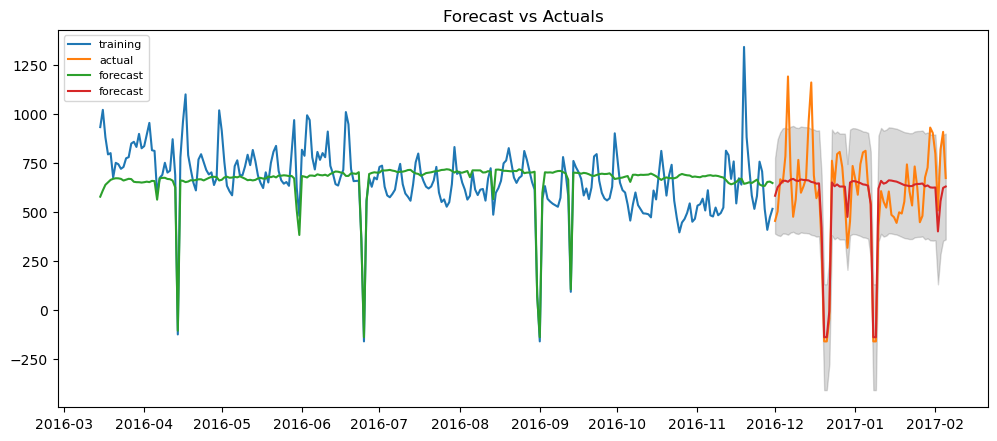

Train_MAPE= 16.42%
Test_MAPE= 20.41%
RMSE= 159.08


In [89]:
# Build Model
# NO2 Gas
# ARIMA model order=(0, 0, 5))   
model = ARIMA(train_NO2, exog=exog_train, order=(0, 0, 5))  
fitted = model.fit(disp=-1)  

# Forecast
fc1, se1, conf1 = fitted.forecast(261, exog=exog_train, alpha=0.05)
fc2, se2, conf2 = fitted.forecast(67, exog=exog_test, alpha=0.05)  # 95% conf


# Make as pandas series
fc_series1 = pd.Series(fc1, index=train_NO2.index)
fc_series2 = pd.Series(fc2, index=test_NO2.index)
lower_series = pd.Series(conf2[:, 0], index=test_NO2.index)
upper_series = pd.Series(conf2[:, 1], index=test_NO2.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_NO2, label='training')
plt.plot(test_NO2, label='actual')
plt.plot(fc_series1, label='forecast')
plt.plot(fc_series2, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
print(f'Train_MAPE= {round(np.mean(np.abs(fc1 - train_NO2.values)/np.abs(train_NO2.values)*100),2)}%')   # MAPE
print(f'Test_MAPE= {round(np.mean(np.abs(fc2 - test_NO2.values)/np.abs(test_NO2.values)*100),2)}%')
print('RMSE=',round(np.mean((fc2 - test_NO2.values)**2)**.5,2)) # RMSE


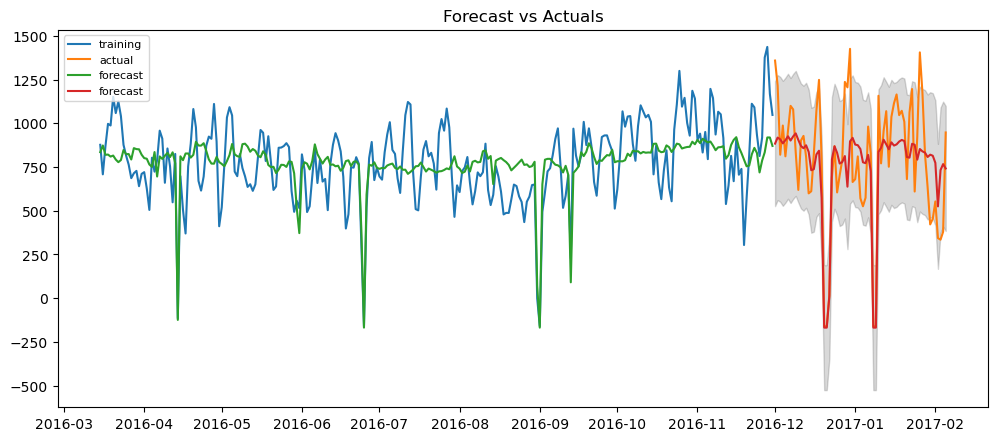

Train_MAPE= 49.73%
Test_MAPE= 26.04%
RMSE= 239.85


In [90]:
# Build Model
# O3 Gas
# ARIMA model order=(0, 0, 0))  
model = ARIMA(train_O3, exog=exog_train, order=(0, 0, 0))  
fitted = model.fit(disp=-1)  

# Forecast
fc1, se1, conf1 = fitted.forecast(261, exog=exog_train, alpha=0.05)
fc2, se2, conf2 = fitted.forecast(67, exog=exog_test, alpha=0.05)  # 95% conf


# Make as pandas series
fc_series1 = pd.Series(fc1, index=train_O3.index)
fc_series2 = pd.Series(fc2, index=test_O3.index)
lower_series = pd.Series(conf2[:, 0], index=test_O3.index)
upper_series = pd.Series(conf2[:, 1], index=test_O3.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_O3, label='training')
plt.plot(test_O3, label='actual')
plt.plot(fc_series1, label='forecast')
plt.plot(fc_series2, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
print(f'Train_MAPE= {round(np.mean(np.abs(fc1 - train_O3.values)/np.abs(train_O3.values)*100),2)}%')   # MAPE
print(f'Test_MAPE= {round(np.mean(np.abs(fc2 - test_O3.values)/np.abs(test_O3.values)*100),2)}%')
print('RMSE=',round(np.mean((fc2 - test_O3.values)**2)**.5,2)) # RMSE

## Model Fitting

### Sarimax

In [169]:
def MAPE(y_actual, y_pred):
    y_actual = y_actual.values.reshape(-1,)
    y_pred = y_pred.values
    return np.mean(np.abs(np.divide((y_actual-y_pred), y_actual))* 100)

### Find the best combinations of the parameters for Sarimax model

In [171]:
# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = (0, 1, 2, 3, 4, 5, 6)
d = (0, 1)
q = (0, 1, 2, 3, 4, 5)
# Generate all different combinations of p, q and q triplets
orders = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
seasonal_orders = [(1, 0, 0, 12),(1, 0, 0, 31),(1, 0, 1, 31),(1, 0, 0, 35)]

In [172]:
gas=['CO', 'HC', 'NO2', 'O3']

### Make a for loop to run all the gases and the orders generated through Sarimax model

Print out the forecasting statistics and sort by rmse because submissions to Kaggle are evaluated on RMSE between forecasts and actual values.

In [173]:
# Sarimax model with grid search parameters
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
prediction_df = pd.DataFrame()
metrics_df = pd.DataFrame(columns=['Gas', 'Model', 'Mape_train', 'Mape_test', 'AIC', 'RMSE'])
for gas in gas:
    for order in orders:
        for seasonal_order in seasonal_orders:
            try:
                    arima_model = SARIMAX(train[gas], exog=exog_train, order=order,
                                         seasonal_order=seasonal_order).fit()
                    pred= arima_model.get_prediction(exog = exog_test, start='2016-03-15', end='2017-02-05').predicted_mean
                    prediction_df[f'{order}, {seasonal_order}'] = pred
                    rmse = round(np.sqrt(mean_squared_error(pred[pred.index>='2016-12-01'],test[gas])),2)
                    mape_train =round(MAPE(train[gas], pred[pred.index<'2016-12-01']),2)
                    mape_test =round(MAPE(test[gas], pred[pred.index>='2016-12-01']),2)
                    metrics_df =metrics_df.append({'Gas':gas, 'Model': f'{order}, {seasonal_order}','Mape_train': mape_train, 'Mape_test':mape_test, 'AIC': arima_model.aic, 'RMSE':rmse},ignore_index=True)
            except:
                pass
                # ignore the error and go on
    print('For Gas:', gas)
    display(metrics_df.loc[metrics_df['Gas'] == gas].sort_values('RMSE'))

For Gas: CO


,Gas,Model,Mape_train,Mape_test,AIC,RMSE
293,CO,"(6, 0, 5), (1, 0, 0, 35)",7.65,11.06,3338.186814,99.50
289,CO,"(6, 0, 4), (1, 0, 0, 35)",7.80,11.11,3337.878442,100.84
60,CO,"(1, 0, 3), (1, 0, 0, 12)",7.15,11.57,2957.787554,101.71
76,CO,"(1, 1, 1), (1, 0, 0, 12)",7.32,12.19,2947.044834,102.18
292,CO,"(6, 0, 5), (1, 0, 1, 31)",8.68,16.82,3354.008266,102.35
...,...,...,...,...,...,...
244,CO,"(5, 0, 4), (1, 0, 1, 31)",8.22,203.00,3301.257944,1300.64
204,CO,"(4, 0, 5), (1, 0, 0, 35)",136.38,244.40,26.000000,1418.90
240,CO,"(5, 0, 3), (1, 0, 0, 31)",305.29,719.12,24.000000,4156.06
283,CO,"(6, 0, 3), (1, 0, 0, 31)",377.27,890.59,26.000000,5338.66


For Gas: HC


,Gas,Model,Mape_train,Mape_test,AIC,RMSE
459,HC,"(2, 1, 5), (1, 0, 0, 31)",9.89,445.42,3016.792255,119.05
446,HC,"(2, 1, 2), (1, 0, 0, 12)",10.23,40.13,3062.432419,120.45
523,HC,"(4, 0, 4), (1, 0, 0, 31)",10.21,134.63,3330.068905,121.28
436,HC,"(2, 0, 5), (1, 0, 1, 31)",10.23,210.00,3210.008790,121.55
435,HC,"(2, 0, 5), (1, 0, 0, 31)",10.45,75.53,3088.399841,122.34
...,...,...,...,...,...,...
428,HC,"(2, 0, 3), (1, 0, 1, 31)",514.96,15969.72,20.000000,6480.37
510,HC,"(4, 0, 0), (1, 0, 0, 31)",1292.11,155677.17,16.000000,14094.28
432,HC,"(2, 0, 4), (1, 0, 1, 31)",4105.62,470944.94,444.803996,54502.53
416,HC,"(2, 0, 0), (1, 0, 1, 31)",9671.38,433241.38,222.474068,85767.58


For Gas: NO2


,Gas,Model,Mape_train,Mape_test,AIC,RMSE
800,NO2,"(3, 0, 3), (1, 0, 0, 12)",11.64,18.58,3172.410825,161.40
949,NO2,"(6, 0, 5), (1, 0, 0, 31)",10.87,18.46,3319.716419,161.50
950,NO2,"(6, 0, 5), (1, 0, 1, 31)",11.50,17.42,3314.426047,162.34
924,NO2,"(5, 1, 4), (1, 0, 0, 35)",10.56,17.76,3112.800107,165.12
968,NO2,"(6, 1, 4), (1, 0, 0, 12)",10.57,18.24,3113.438587,165.23
...,...,...,...,...,...,...
796,NO2,"(3, 0, 2), (1, 0, 0, 12)",15.35,88.98,3295.143497,426.65
942,NO2,"(6, 0, 3), (1, 0, 0, 31)",71.92,106.37,26.000000,444.22
798,NO2,"(3, 0, 2), (1, 0, 1, 31)",11.98,91.58,3231.182116,518.49
899,NO2,"(5, 0, 4), (1, 0, 1, 31)",94.69,128.70,28.000000,623.33


For Gas: O3


,Gas,Model,Mape_train,Mape_test,AIC,RMSE
1279,O3,"(6, 0, 5), (1, 0, 1, 31)",37.44,28.80,3466.991896,231.73
1141,O3,"(3, 0, 5), (1, 0, 1, 31)",42.98,37.48,3537.667092,234.08
1275,O3,"(6, 0, 4), (1, 0, 1, 31)",23.73,26.60,3456.112385,234.52
1180,O3,"(4, 0, 3), (1, 0, 1, 31)",37.54,30.27,3358.974132,236.59
978,O3,"(0, 0, 0), (1, 0, 1, 31)",42.94,34.07,3610.348530,238.86
...,...,...,...,...,...,...
992,O3,"(0, 0, 4), (1, 0, 0, 12)",51.38,83.37,3474.212394,505.48
996,O3,"(0, 0, 5), (1, 0, 0, 12)",51.46,100.80,3458.837082,543.79
1175,O3,"(4, 0, 2), (1, 0, 0, 12)",770.06,391.66,20.000000,1563.64
1222,O3,"(5, 0, 2), (1, 0, 0, 35)",1038.78,618.67,22.000000,2924.70


### Print out the best sarimax models
for each gas
- CO order=(6, 0, 5), seasonal_order=(1, 0, 0, 35)
- HC order=(2, 1, 5), seasonal_order=(1, 0, 0, 31)
- NO2 order=(3, 0, 3), seasonal_order=(1, 0, 0, 12)
- O3  order=(6, 0, 5), seasonal_order=(1, 0, 1, 31)

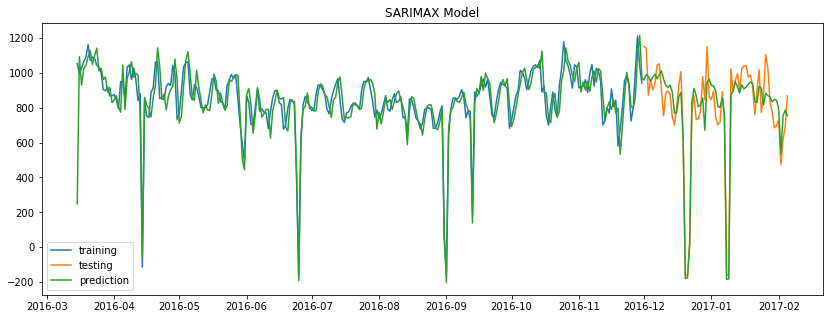

Model Mean Absolute Percentage Error on training data is 7.65%
Model Mean Absolute Percentage Error on testing data is 11.06%
RMSE =  99.49556475213244


In [163]:
# CO Gas
# SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(train['CO'], exog=exog_train, order=(6, 0, 5),seasonal_order=(1, 0, 0, 35)).fit()
pred = sarima_model.get_prediction(exog = exog_test, start='2016-03-15', end='2017-02-05').predicted_mean
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train['CO'], label='training')
ax.plot(test['CO'], label='testing')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMAX Model')
plt.show()
# To evaluate the auto arima model
from sklearn.metrics import mean_absolute_percentage_error
mape_train = mean_absolute_percentage_error(train['CO'], pred[pred.index<'2016-12-01'])
mape_test = mean_absolute_percentage_error(test['CO'], pred[pred.index>='2016-12-01'])
RMSE=np.sqrt(mean_squared_error(pred[pred.index>='2016-12-01'],test['CO']))
print(f'Model Mean Absolute Percentage Error on training data is {mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {mape_test*100:.2f}%')
print('RMSE = ',RMSE)

#### Model diagnostics for CO

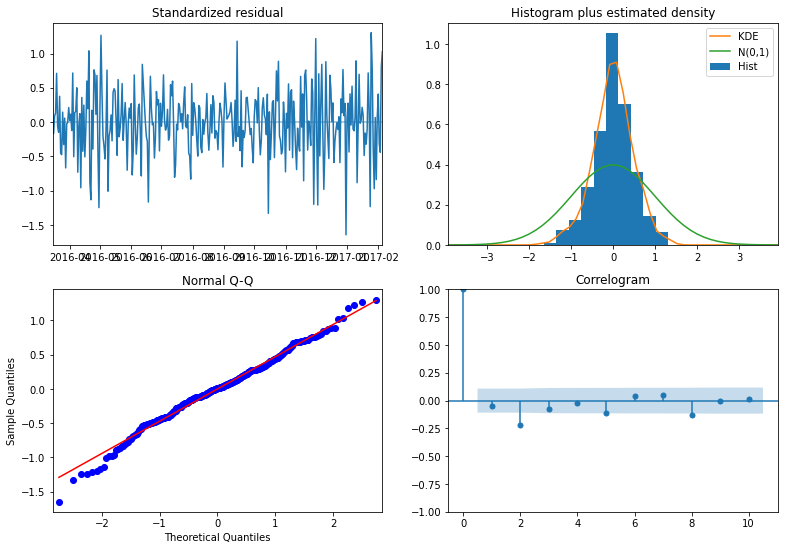

In [51]:
sarima_model.plot_diagnostics(figsize=(13,9))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model.

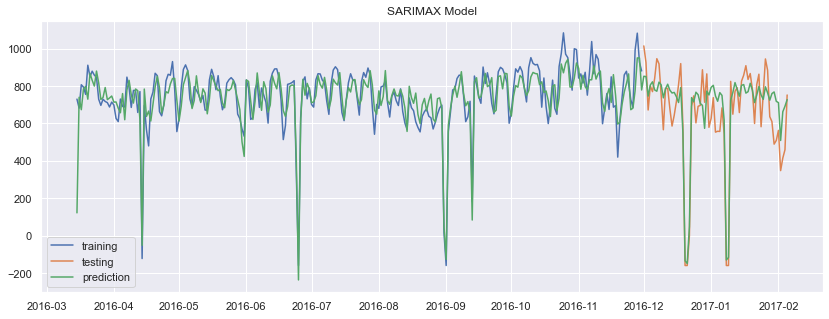

Model Mean Absolute Percentage Error on training data is 9.90%
Model Mean Absolute Percentage Error on testing data is 449.70%
RMSE =  119.06154527895302


In [28]:
# HC Gas
# SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(train['HC'], exog=exog_train, order=(2, 1, 5),seasonal_order=(1, 0, 0, 31)).fit()
pred = sarima_model.get_prediction(exog = exog_test, start='2016-03-15', end='2017-02-05').predicted_mean
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train['HC'], label='training')
ax.plot(test['HC'], label='testing')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMAX Model')
plt.show()
# To evaluate the auto arima model
from sklearn.metrics import mean_absolute_percentage_error
mape_train = mean_absolute_percentage_error(train['HC'], pred[pred.index<'2016-12-01'])
mape_test = mean_absolute_percentage_error(test['HC'], pred[pred.index>='2016-12-01'])
RMSE=np.sqrt(mean_squared_error(pred[pred.index>='2016-12-01'],test['HC']))
print(f'Model Mean Absolute Percentage Error on training data is {mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {mape_test*100:.2f}%')
print('RMSE = ',RMSE)

#### Model diagnostics for HC

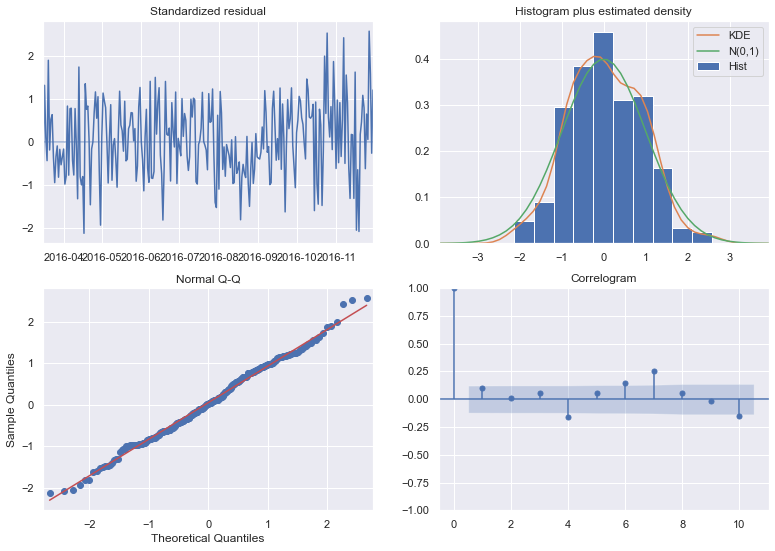

In [29]:
sarima_model.plot_diagnostics(figsize=(13,9))
plt.show()

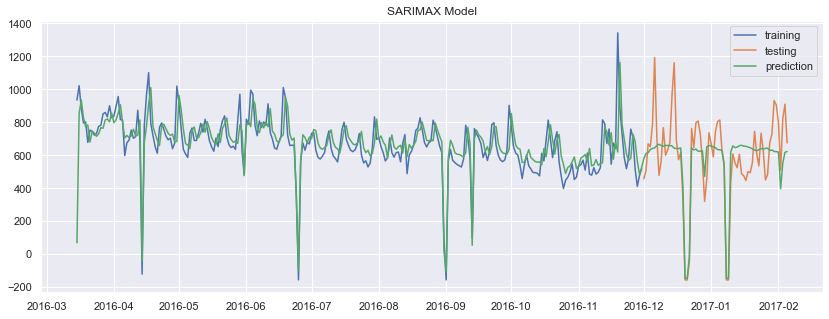

Model Mean Absolute Percentage Error on training data is 11.70%
Model Mean Absolute Percentage Error on testing data is 19.77%
RMSE =  161.36268306008702


In [30]:
# NO2 Gas
# SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(train['NO2'], exog=exog_train, order=(3, 0, 3),seasonal_order=(1, 0, 0, 12)).fit()
pred = sarima_model.get_prediction(exog = exog_test, start='2016-03-15', end='2017-02-05').predicted_mean
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train['NO2'], label='training')
ax.plot(test['NO2'], label='testing')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMAX Model')
plt.show()
# To evaluate the auto arima model
from sklearn.metrics import mean_absolute_percentage_error
mape_train = mean_absolute_percentage_error(train['NO2'], pred[pred.index<'2016-12-01'])
mape_test = mean_absolute_percentage_error(test['NO2'], pred[pred.index>='2016-12-01'])
RMSE=np.sqrt(mean_squared_error(pred[pred.index>='2016-12-01'],test['NO2']))
print(f'Model Mean Absolute Percentage Error on training data is {mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {mape_test*100:.2f}%')
print('RMSE = ',RMSE)

#### Model diagnostics for NO2

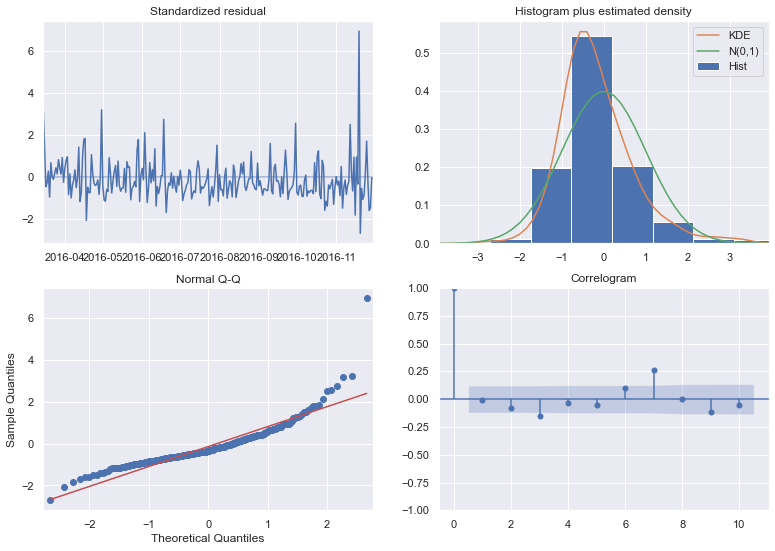

In [31]:
sarima_model.plot_diagnostics(figsize=(13,9))
plt.show()

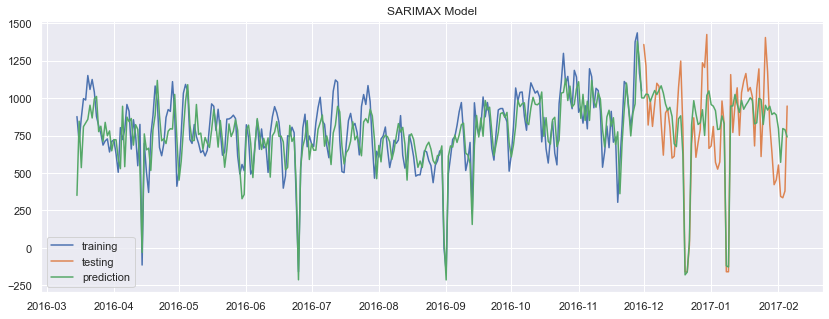

Model Mean Absolute Percentage Error on training data is 15.09%
Model Mean Absolute Percentage Error on testing data is 454.03%
RMSE =  220.61700537824152


In [32]:
# O3 Gas
# SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(train['O3'], exog=exog_train, order=(6, 0, 5),seasonal_order=(1, 0, 1, 31)).fit()
pred = sarima_model.get_prediction(exog = exog_test, start='2016-03-15', end='2017-02-05').predicted_mean
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train['O3'], label='training')
ax.plot(test['O3'], label='testing')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMAX Model')
plt.show()
# To evaluate the auto arima model
from sklearn.metrics import mean_absolute_percentage_error
mape_train = mean_absolute_percentage_error(train['HC'], pred[pred.index<'2016-12-01'])
mape_test = mean_absolute_percentage_error(test['HC'], pred[pred.index>='2016-12-01'])
RMSE=np.sqrt(mean_squared_error(pred[pred.index>='2016-12-01'],test['HC']))
print(f'Model Mean Absolute Percentage Error on training data is {mape_train*100:.2f}%')
print(f'Model Mean Absolute Percentage Error on testing data is {mape_test*100:.2f}%')
print('RMSE = ',RMSE)

#### Model diagnostics for O3

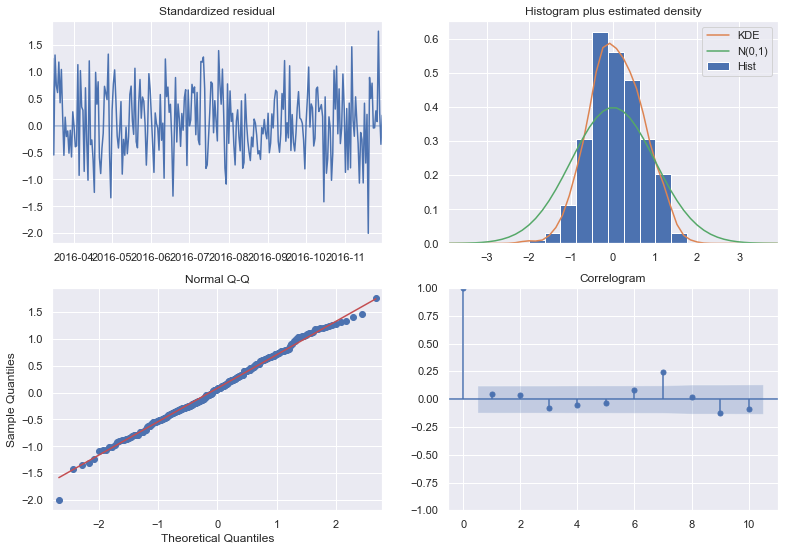

In [33]:
sarima_model.plot_diagnostics(figsize=(13,9))
plt.show()

## Evaluation
Here all the other models have a higher rmse score than the simple moving average, which is used as a baseline so my other models works a lot better than the baseline. 

### Out of Sample data prediction

In [12]:
#Read test data
df_test = pd.read_csv("test.csv")
df_test

,id,Date,T,RH,Gas,Unnamed: 5,Unnamed: 6
0,0,6/2/2017,6.616667,51.734375,CO,NaN,NaN
1,1,7/2/2017,7.613194,43.930903,CO,NaN,NaN
2,2,8/2/2017,7.252083,50.966667,CO,NaN,NaN
3,3,9/2/2017,7.473611,50.166319,CO,NaN,NaN
4,4,10/2/2017,5.571875,46.604167,CO,NaN,NaN
...,...,...,...,...,...,...,...
247,247,5/4/2017,17.554167,50.092708,O3,NaN,NaN
248,248,6/4/2017,15.919792,35.959722,O3,NaN,NaN
249,249,7/4/2017,15.489583,32.213542,O3,NaN,NaN
250,250,8/4/2017,18.381250,33.686458,O3,NaN,NaN


#### Observation

From here we can see that there are 1 column of id, date, T, RH, Gas and 2 empty columns.

In [13]:
#Date column to datetime
df_test['Date'] = pd.to_datetime(df_test['Date'], format='%d/%m/%Y')
df_test

,id,Date,T,RH,Gas,Unnamed: 5,Unnamed: 6
0,0,2017-02-06,6.616667,51.734375,CO,NaN,NaN
1,1,2017-02-07,7.613194,43.930903,CO,NaN,NaN
2,2,2017-02-08,7.252083,50.966667,CO,NaN,NaN
3,3,2017-02-09,7.473611,50.166319,CO,NaN,NaN
4,4,2017-02-10,5.571875,46.604167,CO,NaN,NaN
...,...,...,...,...,...,...,...
247,247,2017-04-05,17.554167,50.092708,O3,NaN,NaN
248,248,2017-04-06,15.919792,35.959722,O3,NaN,NaN
249,249,2017-04-07,15.489583,32.213542,O3,NaN,NaN
250,250,2017-04-08,18.381250,33.686458,O3,NaN,NaN


In [14]:
#Drop Unnamed:5 & Unnamed:6
df_test = df_test.dropna(axis=1, how='all')
df_test

,id,Date,T,RH,Gas
0,0,2017-02-06,6.616667,51.734375,CO
1,1,2017-02-07,7.613194,43.930903,CO
2,2,2017-02-08,7.252083,50.966667,CO
3,3,2017-02-09,7.473611,50.166319,CO
4,4,2017-02-10,5.571875,46.604167,CO
...,...,...,...,...,...
247,247,2017-04-05,17.554167,50.092708,O3
248,248,2017-04-06,15.919792,35.959722,O3
249,249,2017-04-07,15.489583,32.213542,O3
250,250,2017-04-08,18.381250,33.686458,O3


In [15]:
#Split data to specific Gas type
Test_CO = df_test.loc[df_test['Gas'] == 'CO']
Test_HC = df_test.loc[df_test['Gas'] == 'HC']
Test_NO2 = df_test.loc[df_test['Gas'] == 'NO2']
Test_O3 = df_test.loc[df_test['Gas'] == 'O3']

### Convert to best models results to csv

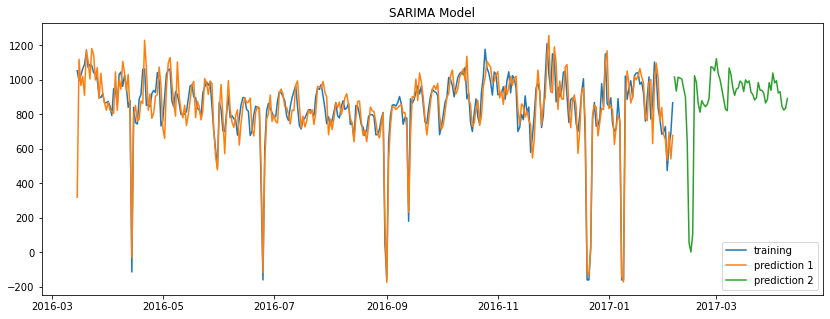

In [49]:
#CO Gas
#Define Train & Test Data
train_data = df['CO']
train_data_Exog = df[['T', 'RH']]
test_data_Exog = Test_CO[['T','RH']]

#SARIMAX model
sarima_model = SARIMAX(train_data, order=(6, 0, 5),seasonal_order=(1, 0, 0, 35), exog = train_data_Exog[['T','RH']]).fit()
pred1 = sarima_model.get_prediction(start = '2016-03-15', end = '2017-02-05', exog = train_data_Exog).predicted_mean
pred2 = sarima_model.get_prediction(start = '2017-02-06', end = '2017-04-09', exog = test_data_Exog).predicted_mean

#Plot
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data, label='training')
ax.plot(pred1, label='prediction 1')
ax.plot(pred2, label='prediction 2')
plt.legend()
plt.title('SARIMA Model')
plt.show()
pred2.to_csv('KaggleTestCO.csv', index = True)

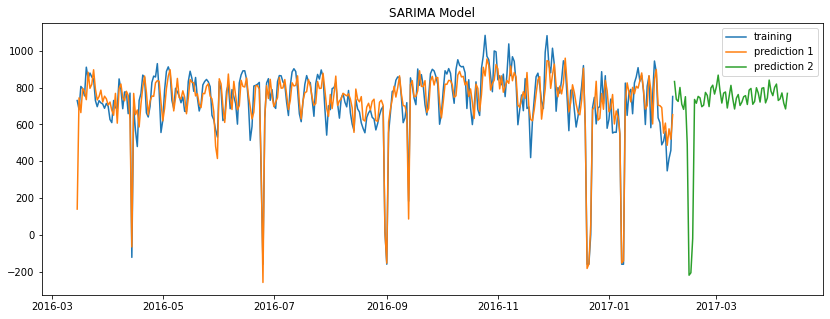

In [193]:
#HC Gas
#Define Train & Test Data
train_data = df['HC']
#test_data = TestCO['Value']
train_data_Exog = df[['T', 'RH']]
test_data_Exog = Test_HC[['T','RH']]

#SARIMAX model
sarima_model = SARIMAX(train_data, order=(2, 1, 5),seasonal_order=(1, 0, 0, 31), exog = train_data_Exog[['T','RH']]).fit()
pred1 = sarima_model.get_prediction(start = '2016-03-15', end = '2017-02-05', exog = train_data_Exog).predicted_mean
pred2 = sarima_model.get_prediction(start = '2017-02-06', end = '2017-04-09', exog = test_data_Exog).predicted_mean

#Plot
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data, label='training')
#ax.plot(test_data, label='testing')
ax.plot(pred1, label='prediction 1')
ax.plot(pred2, label='prediction 2')
plt.legend()
plt.title('SARIMA Model')
plt.show()
pred2.to_csv('KaggleTestHC.csv', index = True)

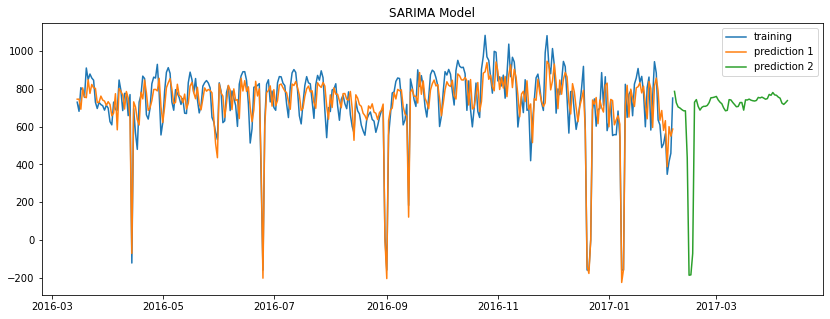

In [23]:
#HC Gas
#Define Train & Test Data
train_data = df['HC']
#test_data = TestCO['Value']
train_data_Exog = df[['T', 'RH']]
test_data_Exog = Test_HC[['T','RH']]

#SARIMAX model
arima_model = sm.tsa.arima.ARIMA(train_data, exog = train_data_Exog[['T','RH']], order=(4, 0, 2)).fit()
pred1 = arima_model.get_prediction(start = '2016-03-15', end = '2017-02-05', exog = train_data_Exog).predicted_mean
pred2 = arima_model.get_prediction(start = '2017-02-06', end = '2017-04-09', exog = test_data_Exog).predicted_mean

#Plot
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data, label='training')
#ax.plot(test_data, label='testing')
ax.plot(pred1, label='prediction 1')
ax.plot(pred2, label='prediction 2')
plt.legend()
plt.title('SARIMA Model')
plt.show()
pred2.to_csv('KaggleTestHC.csv', index = True)

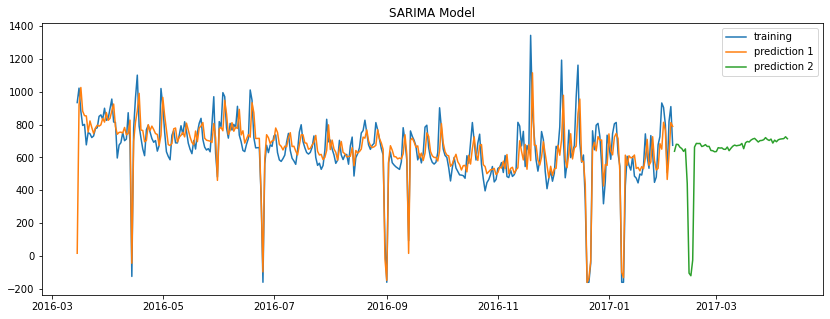

In [194]:
#NO2 Gas
#Define Train & Test Data
train_data = df['NO2']
train_data_Exog = df[['T', 'RH']]
test_data_Exog = Test_NO2[['T','RH']]

#SARIMAX model
sarima_model = SARIMAX(train_data, order=(3, 0, 3),seasonal_order=(1, 0, 0, 12), exog = train_data_Exog[['T','RH']]).fit()
pred1 = sarima_model.get_prediction(start = '2016-03-15', end = '2017-02-05', exog = train_data_Exog).predicted_mean
pred2 = sarima_model.get_prediction(start = '2017-02-06', end = '2017-04-09', exog = test_data_Exog).predicted_mean

#Plot
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data, label='training')
ax.plot(pred1, label='prediction 1')
ax.plot(pred2, label='prediction 2')
plt.legend()
plt.title('SARIMA Model')
plt.show()
pred2.to_csv('KaggleTestNO2.csv', index = True)

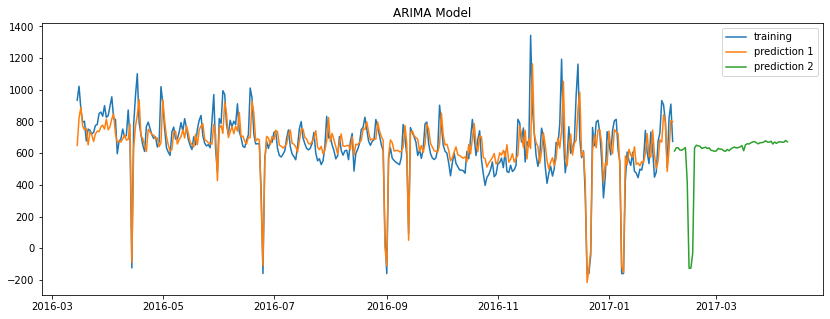

In [24]:
#NO2 Gas
#Define Train & Test Data
train_data = df['NO2']
train_data_Exog = df[['T', 'RH']]
test_data_Exog = Test_NO2[['T','RH']]

#SARIMAX model
arima_model = sm.tsa.arima.ARIMA(train_data, order=(0, 0, 5), exog = train_data_Exog[['T','RH']]).fit()
pred1 = arima_model.get_prediction(start = '2016-03-15', end = '2017-02-05', exog = train_data_Exog).predicted_mean
pred2 = arima_model.get_prediction(start = '2017-02-06', end = '2017-04-09', exog = test_data_Exog).predicted_mean

#Plot
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data, label='training')
ax.plot(pred1, label='prediction 1')
ax.plot(pred2, label='prediction 2')
plt.legend()
plt.title('ARIMA Model')
plt.show()
pred2.to_csv('KaggleTestNO2.csv', index = True)

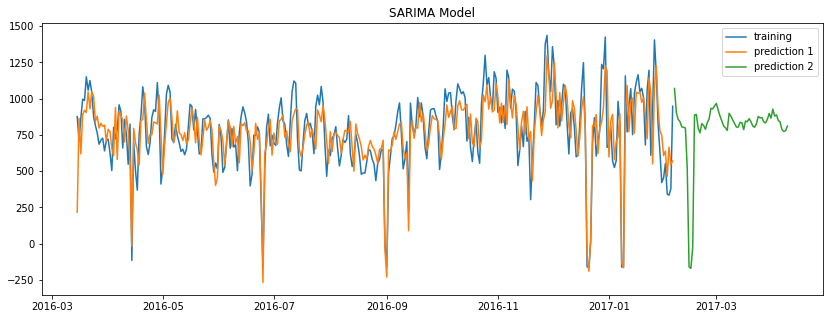

In [197]:
#O3 Gas
#Define Train & Test Data
train_data = df['O3']
train_data_Exog = df[['T', 'RH']]
test_data_Exog = Test_O3[['T','RH']]

#SARIMAX model
sarima_model = SARIMAX(train_data, order=(3, 0, 5),seasonal_order=(1, 0, 1, 31), exog = train_data_Exog[['T','RH']]).fit()
pred1 = sarima_model.get_prediction(start = '2016-03-15', end = '2017-02-05', exog = train_data_Exog).predicted_mean
pred2 = sarima_model.get_prediction(start = '2017-02-06', end = '2017-04-09', exog = test_data_Exog).predicted_mean

#Plot
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data, label='training')
ax.plot(pred1, label='prediction 1')
ax.plot(pred2, label='prediction 2')
plt.legend()
plt.title('SARIMA Model')
plt.show()
pred2.to_csv('KaggleTestO3.csv', index = True)

## conclusion
SARIMAX model can deal with external effects. This feature of the model differs from other models. 
For example, with the air pollution data, the temperature, T and Humidity, H has seasonal effects too. We can’t predict the exact value for these factors if they do not appear in a cyclic or any seasonal behaviour. 
